# Recurrent Neural Networks: Introduction

Countless learning tasks require dealing with sequential data. Image captioning, speech synthesis, and music generation all require that models product outputs consisting of sequences. In other domains, such as time series pediction, video analysis, and musical information retrieval, a model must learn from inputs that are sequences. These demands often arise simualteneously: tasks such as translating passages of text from one natural language to another, enganging in dialogue, or controlling a robot, demand that models both ingest and output sequentially-structured data. 

__Recurrent neural networks (RNNs)__ are deep learning models that capture the dynamics of sequences via recurrent connections, which can be thought of as cycles in the network of nodes. This might seem counterintuitive at first. _After all, it is the feedforward nature of neural networks that makes the order of computation unambiguous_. However, recurrent edges are defined in a precise way that ensures that no such ambiguity can arise. Recurrent neural networks are unrolled across time steps (or sequence steps), with the same underlying parameters applied at each step. While the standard connections are applied synchronously to propagate each layer’s activations to the subsequent layer at the same time step, the recurrent connections are dynamic, passing information across adjacent time steps.

Like neural networks more broadly, RNNs have a long discipline-spanning history, originating as models of the brain popularized by cognitive scientists and subsequently adopted as practical modeling tools employed by the machine learning community. As with deep learning more broadly, this book adopts the machine learning perspective, focusing on RNNs as practical tools which rose to popularity in the 2010s owing to breakthrough results on such diverse tasks as handwriting recognition (Graves et al., 2008), machine translation (Sutskever et al., 2014), and recognizing medical diagnoses (Lipton et al., 2016). We point the reader interested in more background material to a publicly available comprehensive review (Lipton et al., 2015). We also note that sequentiality is not unique to RNNs. For example, the CNNs that we already introduced can be adapted to handle data of varying length, e.g., images of varying resolution. Moreover, RNNs have recently ceded considerable market share to Transformer models, which will be covered in Section 11. However, RNNs rose to prominence as the default models for handling complex sequential structure in deep learning, and remain staple models for sequential modeling to this day. The stories of RNNs and of sequence modeling are inextricably linked, and this is as much a chapter about the ABCs of sequence modeling problems as it is a chapter about RNNs.

Up untill now, we have focused on models whose inputs consisted of a single feature vector __x__. The main change of perspective when developing models capable of processing sequences is that we now focus on inputs that consist of _an ordered list of feature vectors_ __x1, ... , xt__ where each feature vecotr __xt__ indexed by a time step _t_ C Z lies in R. 


### Probability Distribution


_Previously, when dealing with individual inputs, we assumed that they were sampled independently from the same underlying distribution ._ __While we still assume that entire sequences (e.g., entire documents or patient trajectories) are sampled independently, we cannot assume that the data arriving at each time step are independent of each other.__ For example, what words are likely to appear later in a document depends heavily on what words occurred earlier in the document. What medicine a patient is likely to receive on the 10th day of a hospital visit depends heavily on what transpired in the previous nine days.


### Question: What are the implications of this statement?


_This should come as no surprise._ __If we did not believe that the elements in a sequence were related, we would not have bothered to model them as a sequence in the first place.__ Consider the usefulness of the auto-fill features that are popular on search tools and modern email clients. They are useful precisely because it is often possible to predict (imperfectly, but better than random guessing) what likely continuations of a sequence might be, given some initial prefix. __For most sequence models, we do not require independence, or even stationarity, of our sequences. Instead, we require only that the sequences themselves are sampled from some fixed underlying distribution over entire sequences.__

### Other implications: 

This flexible approach, allows for such phenomena as:

1) documents looking significantly different at the beginning than at the end, or 
2) patient status evolving either towards recovery or towards death over the course of a hospital stay; and 
3) customer taste evolving in predictable ways over course of continued interaction with a recommender system.

### Goal: 
__Predict sequentially structured targets based on sequentially structured inputs (e.g., machine translation or video captioning).__

Such sequence-to-sequence tasks take two forms: 

1) __aligned__: where the input at each time step aligns with a corresponding target(e.g., part of speech tagging);
2) __unaligned__: where the input and target do not necessarily exhibit a step-for-step correspondence (e.g., machine translation).


 ## Problem: 
 __Unsupervised density modeling__ (also called sequence modeling). Here, given a collection of sequences, our goal is to estimate the probability mass function that tells us how likely we are to see any given sequence.


### Sequence Models

Sometimes, especially when working with language, we wish to __estimate the joint probability of an entire sequence__. This is a common task when working with sequences composed of discrete _tokens_, such as words. 

Generally, these estimated functions are called _sequence models_ and for natural language data, they are called __language models__. Note: the field of sequence modeling has been driven so much by natural language processing that we often describe sequence models as "language models", even when dealing with non-language data. Language models prove useful for all sorts of reasons. Sometimes we want to evaluate the likelihood of sentences. 

#### Why would we want to estimate the joint probability of an entire sequence? 
For example, we might wish to compare the naturalness of two candidates outputs generated by a machine translation system or by a speech recognition system. 

#### Advantages: 
Language modeling gives us: 
* capacity to _evaluate_ likelihood
* the ability to _sample_ sequences
* and even to _optimize_ for the most likely sequences.



## Topics To Look Deep Into the Math: 

* Markov Models
* Joint Probability
* The order of decoding (__why factorizing text from left-to-right for most languages, and right-to-left for Arabic and Hebrew__).

In [1]:
%matplotlib inline
import torch 
from torch import nn
from d2l import torch as d2l

## Autoregressive Models

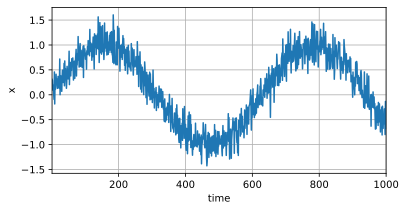

In [2]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [3]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

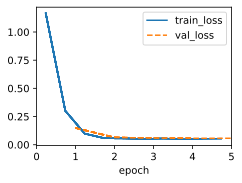

In [4]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

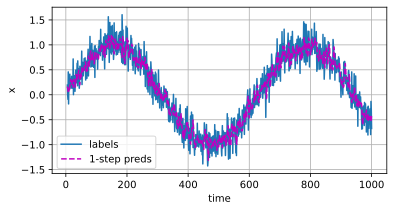

In [5]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

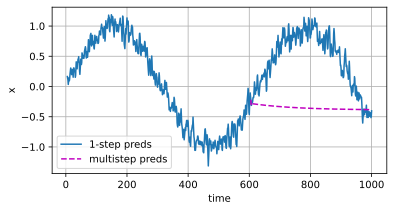

In [6]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

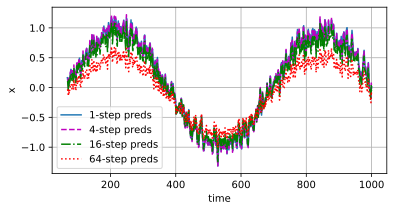

In [7]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))